---
title: Solving Kinematics Numerically with Python
type: submodule
---


# Solving Kinematics Numerically with Python


## Introduction

This module takes you through solving the motion of a device by using a numerical nonlinear solver to solve a complex system of constraint equations.  We will be using a number of Python packages to do this.

Note that solving kinematics numerically can prove troublesome, as the lack of a symbolic system of equations prevents us from analyzing those equations for situations when the system approaches a singularity, or when the initial guess for the state of the system is far away from the solution.  We will use a number of techniques to mitigate some of these problems but they are not always solvable.


## Import Packages

Import the packages you will need.  You will need _numpy_ for array handling, _matplotlib_'s plotting capabilities, the _scipy.optimize_ package to do nonlinear multidimensional solving, and the _math_ package for trig constants and functions.

In [1]:
# This line produces inline images in jupyter notebook
%matplotlib inline

In [2]:
# import all the packages necessary for running the code
import numpy
import matplotlib.pyplot as plt
import scipy.optimize
import math

## Constraint Equations
We will define some functions which will assist you in creating constraint equations for your mechanism.  These functions will be used over and over to define fixed elements of your design, such as the angle between two links, the length of a link, or the absolute angle between two vectors (using a reference).  

### Length of a Vector

First you want to define a length constraint.  Assume a numpy array is fed in.  The function should return the length of the vector:

In [3]:
def length(v1):
    '''
    finds the length of a vector
    
    :param v1: the vector
    :type v1: tuple or list of floats
    :rtype: float
    '''
    v1 = numpy.array(v1).flatten()
    l = (v1.dot(v1))**.5
    return l

### Inner angle between vectors
Next you want to use the identity $\vec{v1}\cdot \vec{v2} = \left|\vec{v1}\right| \left|\vec{v2}\right|\cos{\theta}$.  This equation returns the inner angle between vectors without considering the direction of each vector.  It is useful, however, because given a valid initial condition, this formula can be used to maintain a fixed angle between vectors.

In [4]:
def inner_angle(v1,v2):
    '''
    finds the interior angle between two vectors
    
    :param v1: the first vector
    :type v1: tuple or list of floats
    :param v2: the second vector
    :type v2: tuple or list of floats
    :rtype: float
    '''
    v1 = numpy.array(v1).flatten()
    l1 = length(v1)
    v2 = numpy.array(v2).flatten()
    l2 = length(v2)
    cost = numpy.dot(v1,v2)/l1/l2
    t = math.acos(cost)
    return t

### Absolute angle between vectors

Sometimes it is necessary to specify the angle between two directed vectors.  This cannot be done using only sine or cosine due to their limited range when computing inverse sines and inverse cosines.  the ```atan2``` function may be used in code, but computing the absolute angle between vectors has two solutions unless you supply a third orientation vector v3, indicating the handedness of the solution you prefer.  We will assume that the desired reference vector is a unit vector in the positive z direction, but this can be supplied as an optional third term.  The following function has some error proofing code in it to ensure that the supplied reference is considered in determining which answer to use in solving the total angle between two vectors.

In [5]:
def total_angle(v1,v2,v3=None):
    '''
    finds the interior angle between two vectors
    
    :param v1: the first vector
    :type v1: tuple or list of floats
    :param v2: the second vector
    :type v2: tuple or list of floats
    :rtype: float
    '''

    v1 = numpy.array(v1).flatten()
    if len(v1)==2:
        v1 = numpy.r_[v1,0]
        v3 = numpy.array([0,0,1])

        v2 = numpy.array(v2).flatten()
    if len(v2)==2:
        v2 = numpy.r_[v2,0]
        v3 = numpy.array([0,0,1])

    costheta = numpy.dot(v1,v2)
    sintheta  = numpy.cross(v1,v2)
    l_sintheta = length(sintheta)
    neg = sintheta.dot(v3)
    if neg<0:
        neg = -1
    else:
        neg=1
    theta = math.atan2(neg*l_sintheta,costheta)
    return theta    

## Angle Between Planes
This function finds the angle between two planes

In [6]:
def angle_between_planes(v1,v2,v3):
    '''measures the angle between planes.  
    v1 and v2 are two vectors which define one plane
    v2 and v3 define the third plane.'''
    
    n1 = numpy.cross(v1,v2)
    n2 = numpy.cross(v2,v3)
    return total_angle(n1,n2,v2)

## Constraint Equations Creation

The next function which is generated is responsible for generating and evaluating all the constraint equations for a given system.  Consider a four-bar linkage of four vectors 

![four bar linkage](/figures/kinematics/fourbar.png)

The planar four bar linkage can be defined by four points: $p_1$, $p_2$, $p_3$, and $p_4$.  The distance between these points is fixed by a rigid link.  Additionally, you can see that link 1 is rigidly attached to the world frame, which defines both its position and orientation.  For the 8 unknowns of the system, there must be 8 equations which can fully define the position of those four planar vectors.

To sum them up:

* Four length constraints
* One point($p_1$) fixed at a set of coordinates
* $v_1$ orientation fixed in space

What is left?  The internal configuration of the four-bar linkage.  This can be determined by an extra equation defining the angle between $v_1$ and $v_4$, for example.  This is the single degree of freedom for the four-bar linkage itself.  In this example, $q$ may be considered the input variable which determines the configuration of the entire four-bar linkage.  Adding that final constraint sums to 8 constraint equations to match the 8 unknown variables in the system.

### Implementation in Python
To solve these equations in python requires the use of the ```scipy.optimize``` module.  The ```minimize``` function takes a function and an initial guess for a number of variables, and attempts to reduce the error produced by the function.  So our description of our kinematic constraint equations must result in the form of a function that returns the error of a guess made by the ```scipy.optimize.minimize``` function.

But what if we want to build an arbitrary four-bar linkage?  If we supply specific constraint equations and a value for q, we will have to regenerate a new four-bar function for each design and configuration.  So instead, we wrap the four-bar constraint error calculation in another function which takes in our desired design and configuration variables, ```q1,dl1,dl2,dl3,dl4```.  This wrapper permits us to reuse the calc_fourbar() function for any four-bar linkage for which we have a set of desired link lengths and input angle.  The implementation can be seen below:

In [7]:
p0_ini = 0,0
p1_ini = 1,0
p2_ini = 1,1
p3_ini = -1,-1
p4_ini = .5,-.5
p_ini = numpy.array([p0_ini,p1_ini,p2_ini,p3_ini,p4_ini])

define a list of label strings for labeling points

In [8]:
point_text = ['p0','p1','p2','p3','p4']

Define a list of vectors by the index of the points used

In [9]:
vector_order = []
vector_order.append((0,1))
vector_order.append((1,2))
vector_order.append((2,3))
vector_order.append((3,0))
vector_order.append((2,4))
vector_order.append((3,4))
vector_order = numpy.array(vector_order)

For each vector, define the initial vector as the difference from point 1 minus point 0

In [10]:
v_ini = p_ini[vector_order[:,1]]-p_ini[vector_order[:,0]]
v_ini

array([[ 1. ,  0. ],
       [ 0. ,  1. ],
       [-2. , -2. ],
       [ 1. ,  1. ],
       [-0.5, -1.5],
       [ 1.5,  0.5]])

Calculate the initial length

In [11]:
l_ini = [length(item) for item in v_ini]
l_ini

[1.0,
 1.0,
 2.8284271247461903,
 1.4142135623730951,
 1.5811388300841898,
 1.5811388300841898]

Compute the text location as halfway between point 0 and 1 for each vector

In [12]:
text_location = (p_ini[vector_order[:,1]]+p_ini[vector_order[:,0]])/2
text_location

array([[ 0.5 ,  0.  ],
       [ 1.  ,  0.5 ],
       [ 0.  ,  0.  ],
       [-0.5 , -0.5 ],
       [ 0.75,  0.25],
       [-0.25, -0.75]])

Add labels for labeling the vector midpoint

In [13]:
vector_text = ['v0','v1','v2','v3','v4','v5']

Create a function that plots a mechanism 

In [14]:
def plot_mechanism(point_location,text_location=None):
    for item in vector_order:
        plt.plot(*(point_location[item,:3].T),'ko-')

    if text_location is not None:
        for item,text in zip(point_location,point_text):
            ax.text(x=item[0],y=item[1],s=text)

        for item,text in zip(text_location,vector_text):
            ax.text(x=item[0],y=item[1],s=text)


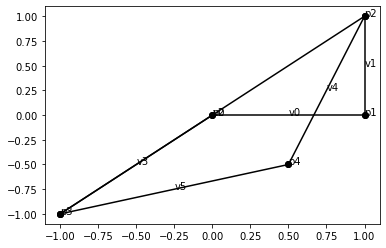

In [15]:
fig = plt.figure();
ax = fig.add_subplot(111)
plot_mechanism(p_ini,text_location)
plt.show()

In [16]:
def gen_function(q1,dl1,dl2,dl3,dl4,dl5,dl6):
    def calc_fourbar(arguments):
        # break arguments variable into 8 discrete variables, 2 for each planar point in the four-bar linkage
        x0,y0,x1,y1,x2,y2,x3,y3,x4,y4 = arguments
        
        #Create four points: p1, p2, p3, p4
        p0 = numpy.array([x0,y0])
        p1 = numpy.array([x1,y1])
        p2 = numpy.array([x2,y2])
        p3 = numpy.array([x3,y3])
        p4 = numpy.array([x4,y4])

        
        #create new point array using inputs of function
        p = numpy.array([p0,p1,p2,p3,p4])
        
        #create new vector array using vector ordering defined above
        v = p[vector_order[:,1]]-p[vector_order[:,0]]
        
        #create new length vector
        l = [length(item) for item in v]

        # Define the x and y axis unit vectors
        x_axis = numpy.array([1,0])
        y_axis = numpy.array([0,1])

        # define the error variable for holding all mechanism error calcs
        error = []

        # Compute the error in the structure as the absolute, cumulative 
        # difference between the link lengths and their desired lengths
        error.append([l[0]-dl1])
        error.append([l[1]-dl2])
        error.append([l[2]-dl3])
        error.append([l[3]-dl4])
        error.append([l[4]-dl5])
        error.append([l[5]-dl6])
        
        # add the desired input angle q1 minus the actual angle as another error component to be solved
        error.append([total_angle(v[0],-v[3])-q1*math.pi/180])
        #error.append([inner_angle(-v4,y_axis)-q1*math.pi/180+math.pi/2])
        
        # add two more constraints defining p1 as fixed at (0,0)
        error.append([p[0,0]-0])
        error.append([p[0,1]-0])
        
        # define v1 to be parallel to the x axis.
        error.append([inner_angle(v[0],x_axis)-0])

        # turn the error list into a vector
        error1 =numpy.array(error)
        
        # return the square root of the sum of squared errors.  The length function that we wrote earlier does that.
        return length(error1)
    
    return calc_fourbar

To test the function we simply need to create a valid initial guess for the initial locations of the 8 variables ```x1,y1,x2,y2,x3,y3,x4,y4```

In [17]:
ini = list(p_ini.flatten())

as well as a set of design variables for ```dl1,dl2,dl3,dl4```.

In [18]:
design = numpy.array([4,2,4.4,1,5,3])

and a state for the one configuration variable ```q1```

In [19]:
q1=-170

In [20]:
function=gen_function(q1,*design)
result  = scipy.optimize.minimize(function,ini)
x = result.x
x =x.reshape((5,2))

Compute the error of the resulting configuration found.  If it is near zero, it was able to find a solution

In [21]:
result.fun

6.995398416354163e-08

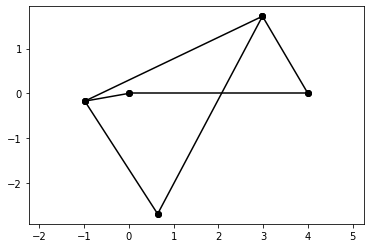

In [22]:
fig = plt.figure();
ax = fig.add_subplot(111)
plot_mechanism(x)
plt.axis('equal')
plt.show()

## Computing a Path
But what if we want to compute more than one configuration in the same plot?  We need to re-run the optimize function with different values for q.  The example below does just that.  Additionally, we only want to show valid solutions, so we add some error proofing to check whether a solution has error below a desired tolerance.

In [23]:
all_q = numpy.r_[-170:181:10]
path = []
q_in = []
ini=result.x
for q1 in all_q:
    function=gen_function(q1,*design)
    result  = scipy.optimize.minimize(function,ini)
    points = result.x
    points =points.reshape((5,2))

    # Only add solution to path if the error is smaller than some nominal value
    print(result.fun)

    if result.fun<1e-1:
        path.append(points)
        q_in.append(q1)
        ini = result.x

path = numpy.array(path)
q_in = numpy.array(q_in)

6.994958769426199e-08
9.03578396742785e-08
6.818126377658796e-08
1.1818014822372901e-07
1.3004526572734587e-07
7.467395056150183e-08
1.2559675148416404e-07
1.4897331305062183e-07
1.253274772729213e-07
1.258116374074979e-07
1.505113906941631e-07
1.1481247697290997e-07
1.3302576309248917e-07
1.5438581509636946e-07
1.4823286472018718e-07
8.048563077184548e-08
1.501539143887747e-07
8.411210379488795e-08
1.3379806951996817e-07
5.470048532108741e-08
7.428209498159685e-08
9.595800307845717e-08
1.1400509698539673e-07
1.203941078844774e-07
1.1868997192356723e-07
9.960076488049228e-08
9.571107464619422e-08
6.135278614690043e-08
7.810011261766794e-08
8.497313988110125e-08
8.837061348200097e-08
8.54950552319171e-08
8.865031358808815e-08
1.427182998700313e-07
7.347182723175156e-08
0.059675897246800585


Plotting the result...

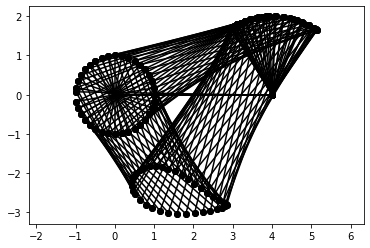

In [24]:
f = plt.figure()
a = f.add_subplot(111)
for item in path:
    plot_mechanism(item)
plt.axis('equal')
plt.savefig('f1.png')

## Computing The Jacobian

Now consider we want to look at an end-effector attached to $\vec{v}_3$.  Plotting the end effector p4:

In [25]:
path.shape

(36, 5, 2)

This plots as the following set of points:

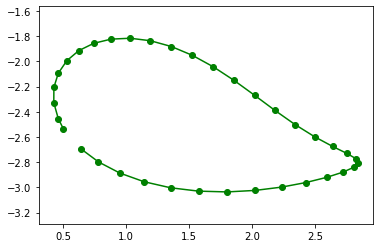

In [26]:
plt.figure()
p4 = path[:,4,:]
#p4 = numpy.r_[p4,p4[0:1]]
plt.plot(p4[:,0],p4[:,1],'go-')
plt.axis('equal')
plt.savefig('f2.png')

But what if we're only interested in the portion of the path where the end effector is supposed to be touching the ground?  Restricting to that portion of the path:

In [27]:
y_out = numpy.vstack([p4,p4[0:2]])
y_out

array([[ 0.64264265, -2.69384763],
       [ 0.7828071 , -2.79823562],
       [ 0.95188307, -2.88646359],
       [ 1.14481075, -2.95549859],
       [ 1.35560967, -3.00354474],
       [ 1.57761488, -3.03016873],
       [ 1.80367917, -3.0363504 ],
       [ 2.02631997, -3.02444975],
       [ 2.23779282, -2.99806976],
       [ 2.43010895, -2.96177114],
       [ 2.59504363, -2.92057242],
       [ 2.72424749, -2.87916297],
       [ 2.8096761 , -2.84079601],
       [ 2.8446389 , -2.80599015],
       [ 2.82567041, -2.77151729],
       [ 2.75487839, -2.73055544],
       [ 2.64131426, -2.6748451 ],
       [ 2.49927055, -2.59849718],
       [ 2.34322093, -2.50118151],
       [ 2.18279387, -2.38830935],
       [ 2.02157382, -2.26852097],
       [ 1.85940198, -2.1508784 ],
       [ 1.69523179, -2.04329031],
       [ 1.52883464, -1.9520413 ],
       [ 1.36136489, -1.88182058],
       [ 1.19531724, -1.83586468],
       [ 1.03425529, -1.81608172],
       [ 0.88249039, -1.82314016],
       [ 0.74476959,

In [28]:
q_in = numpy.r_[q_in,q_in[0:2]]
q_in

array([-170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,  -70,
        -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,   40,
         50,   60,   70,   80,   90,  100,  110,  120,  130,  140,  150,
        160,  170,  180, -170, -160])

In [29]:
range_min = 0
range_max = 11

In [30]:
if range_min>=0:
    y_out = p4[range_min:range_max]
    q_in = q_in[range_min:range_max]
else:
    y_out = numpy.vstack([p4[range_min:,:],p4[0:range_max,:]])
    q_in = numpy.r_[q_in[range_min:],q_in[0:range_max]]

Now we may calculate the relative change in position of the end-effector (in green) between each step as a function of the change in input angle $q$.

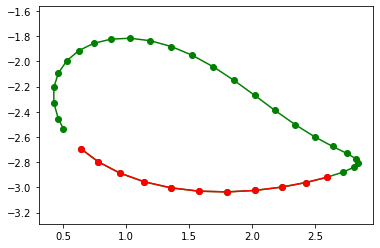

In [31]:
f = plt.figure()
a = f.add_subplot(111)

#for item in path[range_min:range_max]:
#    plot_mechanism(item)
    
a.plot(p4[:,0],p4[:,1],'go-')    
a.plot(y_out[:,0],y_out[:,1],'ro-')    
plt.axis('equal')
plt.savefig('f3.png')

We use the trapezoidal rule to find the slope in y as a function of the previous and next neighbors of each point in the path.  For a path of n points this will produce n-2 sets of partial derivatives

In [32]:
dy = y_out[2:,:]-y_out[:-2,:]
dy

array([[ 0.30924041, -0.19261596],
       [ 0.36200364, -0.15726297],
       [ 0.40372661, -0.11708114],
       [ 0.43280413, -0.07467014],
       [ 0.4480695 , -0.03280566],
       [ 0.44870509,  0.00571898],
       [ 0.43411364,  0.03828064],
       [ 0.40378898,  0.06267861],
       [ 0.35725081,  0.07749734]])

In [33]:
dq = q_in[2:]-q_in[:-2]
dq

array([20, 20, 20, 20, 20, 20, 20, 20, 20])

In [34]:
dq.shape

(9,)

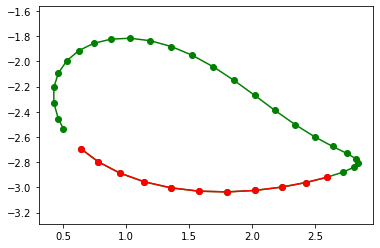

In [35]:
f = plt.figure()
a = f.add_subplot(111)

#for item in path[range_min:range_max]:
#    plot_mechanism(item)
    
a.plot(p4[:,0],p4[:,1],'go-')    
a.plot(y_out[:,0],y_out[:,1],'ro-')    
plt.axis('equal')
plt.savefig('f3.png')

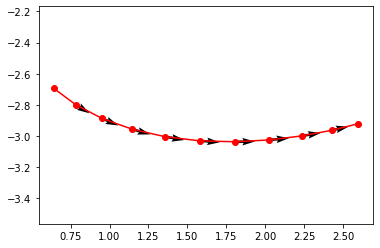

In [36]:
plt.figure()
plt.plot(y_out[:,0],y_out[:,1],'ro-')    
plt.quiver(y_out[1:-1,0],y_out[1:-1,1],dy[:,0],dy[:,1])
plt.axis('equal')
plt.show()


Dividing dy over dq produces 10, 2x1 Jacobian matrices, 1 for each interior point in the motion path.

In [37]:
J=(dy.T/dq.T)
J.shape

(2, 9)

In [38]:
J

array([[ 0.01546202,  0.01810018,  0.02018633,  0.02164021,  0.02240348,
         0.02243525,  0.02170568,  0.02018945,  0.01786254],
       [-0.0096308 , -0.00786315, -0.00585406, -0.00373351, -0.00164028,
         0.00028595,  0.00191403,  0.00313393,  0.00387487]])

Now let's find the torque required to accelerage a 1-kg mass forward at 1g, while holding itself up against gravity:

In [39]:
m = 1 #kg
g = 9.81 #m/s^2
fx = m*g
fy = -m*g
f = numpy.array([[fx,fy]]).T
t = J.T.dot(f)
t #N-m

array([[0.24616055],
       [0.25470027],
       [0.2554562 ],
       [0.24891613],
       [0.23586927],
       [0.21728469],
       [0.19415609],
       [0.16731464],
       [0.13721908]])

In [40]:
t.max()

0.2554562024243693

In [41]:
t.min()

0.13721907554495927

Thus, the torque required by a motor to hold those forces specified by $f_x$ and $f_y$ is around .25 N-m in the worst case.

In [42]:
motor_speed = 500#rpm
dq_dt = motor_speed*2*math.pi/60
velocity = J*dq_dt

In [43]:
velocity[0,:]

array([0.80958951, 0.94772333, 1.05695379, 1.13307856, 1.17304321,
       1.17470717, 1.13650686, 1.05711709, 0.93528043])

In [44]:
f

array([[ 9.81],
       [-9.81]])

In [45]:
P = t.dot(dq_dt)
P

array([[12.88893646],
       [13.33607515],
       [13.37565548],
       [13.03321797],
       [12.35008598],
       [11.37699962],
       [10.1659891 ],
       [ 8.76057407],
       [ 7.18477399]])